In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# load the data
df = pd.read_csv('notebooks/rapprochements/RNC/rnic_ff_2023_france.csv', sep=';')

/tmp/ipykernel_41140/161606633.py:2: DtypeWarning: Columns (7,8,40,51,57,69,70,72,73,74,76,77,78,79,80,85,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('notebooks/rapprochements/RNC/rnic_ff_2023_france.csv', sep=';')


In [ ]:
df.head()

In [4]:
# number of rows
print(f"Number of rows: {len(df)}")

Number of rows: 908579


In [ ]:
# number of rows without adress_ref, ad_compl1, ad_compl2, ad_compl3
df[df['adress_ref'].isnull() & df['ad_compl1'].isnull() & df['ad_compl2'].isnull() & df['ad_compl3'].isnull()].shape

In [5]:
# filter the df, keep rows with adress_ref, ad_compl1, ad_compl2, ad_compl3
df_with_address = df[~df['adress_ref'].isnull() | ~df['ad_compl1'].isnull() | ~df['ad_compl2'].isnull() | ~df['ad_compl3'].isnull()]
df_with_address.shape

(562773, 123)

In [ ]:
# select only the columns that we need
df_subset_col = df_with_address[["idcopro", "num_immat", "adress_ref", "ad_compl1", "ad_compl2", "ad_compl3"]]

In [ ]:
df_subset_col.head()

In [ ]:
# create a new column containing a list of the address as an array
df_list = df_subset_col
df_list["adresse"] = df_subset_col[["adress_ref", "ad_compl1", "ad_compl2", "ad_compl3"]].values.tolist()

# select only the columns that we need
df_list = df_list[["idcopro", "num_immat", "adresse"]]
df_list.head()

In [ ]:
# explode and filter out nan values
df_explode = df_list.explode("adresse").dropna(subset=["adresse"])
df_explode.head()

In [ ]:
# clean the addresses
df_clean = df_explode

df_clean["adresse_clean"] = df_clean["adresse"].str.replace(" bd ", " boulevard ")

# we don't clean "r" because it can be "rue" or "route"
#df_geocoder["adresse_clean"] = df_geocoder["adresse"].str.replace(" r ", " rue ")

df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" av ", " avenue ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" all ", " allée ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" imp ", " impasse ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" pl ", " place ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" sq ", " square ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" rte ", " route ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" che ", " chemin ")
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace(" qu ", " quai ")

# remove from the adress column "RESIDENCE XYZ - " where XYZ can be any string of lower/uppercase letters or space
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace("^RESIDENCE [A-Za-z ]* - ", "", regex=True)
df_clean["adresse_clean"] = df_clean["adresse_clean"].str.replace("^LE[A-Za-z ]* - ", "", regex=True)

In [ ]:
df_clean.head(1000)

In [ ]:
df_ready = df_clean[["idcopro", "num_immat", "adresse_clean"]]
df_ready.shape

In [ ]:
df_ready.to_csv('notebooks/rapprochements/RNC/geocode_this.csv', index=False)

In [ ]:
from batid.services.geocoders import BanBatchGeocoder
from io import StringIO

geocoder = BanBatchGeocoder()
response = geocoder.geocode_file('notebooks/rapprochements/RNC/geocode_this.csv', columns=['adresse_clean'])
response_csv = StringIO(response.text)
df_geocoded = pd.read_csv(response_csv, sep=',')
df_geocoded.to_csv('notebooks/rapprochements/RNC/geocoded.csv', index=False)

In [6]:
df_geocoded = pd.read_csv('notebooks/rapprochements/RNC/geocoded.csv')

/tmp/ipykernel_41140/843552632.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_geocoded = pd.read_csv('notebooks/rapprochements/RNC/geocoded.csv')


<Axes: >

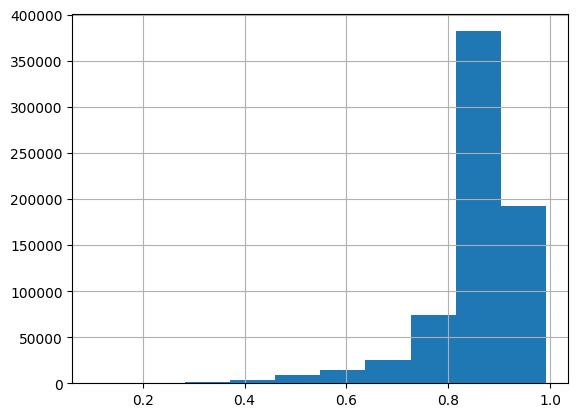

In [7]:
# histogram of the result_score column
df_geocoded["result_score"].hist()

In [8]:
df_geocoded.shape

(702480, 21)

In [10]:
# keep only the rows where the result_type is "housenumber" and the quality is good
df_housenumber = df_geocoded[(df_geocoded["result_type"] == "housenumber") & (df_geocoded["result_score"] > 0.8)]
df_housenumber.shape

(544191, 21)

In [8]:
df_housenumber.head(20)

,idcopro,num_immat,adresse_clean,latitude,longitude,result_label,result_score,result_score_next,result_type,result_id,result_housenumber,result_name,result_street,result_postcode,result_city,result_context,result_citycode,result_oldcitycode,result_oldcity,result_district,result_status
1,RNC_AE9848722,AE9848722,34 r boulegon 13100 Aix-en-Provence,43.531113,5.450111,34 Rue Boulegon 13100 Aix-en-Provence,0.877317,NaN,housenumber,13001_0370_00034,34,34 Rue Boulegon,Rue Boulegon,13100.0,Aix-en-Provence,"13, Bouches-du-Rhône, Provence-Alpes-Côte d'Azur",13001,NaN,NaN,NaN,ok
2,RNC_AI0140434,AI0140434,23 r du bourg 26160 Saint-Gervais-sur-Roubion,44.583331,4.890884,23 Rue du Bourg 26160 Saint-Gervais-sur-Roubion,0.872951,0.646619,housenumber,26305_0077_00023,23,23 Rue du Bourg,Rue du Bourg,26160.0,Saint-Gervais-sur-Roubion,"26, Drôme, Auvergne-Rhône-Alpes",26305,NaN,NaN,NaN,ok
3,RNC_AI0140434,AI0140434,21 r du bourg 26160 Saint-Gervais-sur-Roubion,44.583245,4.890838,21 Rue du Bourg 26160 Saint-Gervais-sur-Roubion,0.872951,0.646619,housenumber,26305_0077_00021,21,21 Rue du Bourg,Rue du Bourg,26160.0,Saint-Gervais-sur-Roubion,"26, Drôme, Auvergne-Rhône-Alpes",26305,NaN,NaN,NaN,ok
4,RNC_AD4719878,AD4719878,5 allée des fleurs 64500 ST JEAN DE LUZ,43.389435,-1.654222,5 Allée des Fleurs 64500 Saint-Jean-de-Luz,0.855068,0.635166,housenumber,64483_0790_00005,5,5 Allée des Fleurs,Allée des Fleurs,64500.0,Saint-Jean-de-Luz,"64, Pyrénées-Atlantiques, Nouvelle-Aquitaine",64483,NaN,NaN,NaN,ok
5,RNC_AD4719878,AD4719878,5 allée des fleurs 64500 ST JEAN DE LUZ,43.389435,-1.654222,5 Allée des Fleurs 64500 Saint-Jean-de-Luz,0.855068,0.635166,housenumber,64483_0790_00005,5,5 Allée des Fleurs,Allée des Fleurs,64500.0,Saint-Jean-de-Luz,"64, Pyrénées-Atlantiques, Nouvelle-Aquitaine",64483,NaN,NaN,NaN,ok
6,RNC_AB0864132,AB0864132,1 r ile de france 66140 CANET EN ROUSSILLON,42.693549,3.033734,1 Rue Ile de France 66140 Canet-en-Roussillon,0.884166,0.635494,housenumber,66037_0270_00001,1,1 Rue Ile de France,Rue Ile de France,66140.0,Canet-en-Roussillon,"66, Pyrénées-Orientales, Occitanie",66037,NaN,NaN,NaN,ok
7,RNC_AH3921590,AH3921590,38 r de folgensbourg 68220 Hésingue,47.573449,7.514798,38 Rue de Folgensbourg 68220 Hésingue,0.862647,0.709490,housenumber,68135_0240_00038,38,38 Rue de Folgensbourg,Rue de Folgensbourg,68220.0,Hésingue,"68, Haut-Rhin, Grand Est",68135,NaN,NaN,NaN,ok
8,RNC_AH8106221,AH8106221,58 r emile zola 69150 Décines-Charpieu,45.763575,4.943922,58 Rue Emile Zola 69150 Décines-Charpieu,0.881289,NaN,housenumber,69275_0440_00058,58,58 Rue Emile Zola,Rue Emile Zola,69150.0,Décines-Charpieu,"69, Rhône, Auvergne-Rhône-Alpes",69275,NaN,NaN,NaN,ok
9,RNC_AC4843603,AC4843603,116 avenue de la liberation 74800 LA ROCHE SUR...,46.069130,6.308087,116 Avenue de la libération 74800 La Roche-sur...,0.961135,NaN,housenumber,74224_0740_00116,116,116 Avenue de la libération,Avenue de la libération,74800.0,La Roche-sur-Foron,"74, Haute-Savoie, Auvergne-Rhône-Alpes",74224,NaN,NaN,NaN,ok
10,RNC_AG3991395,AG3991395,10 r jacques kable 75018 Paris,48.886195,2.361755,10 Rue Jacques Kablé 75018 Paris,0.859511,NaN,housenumber,75118_4794_00010,10,10 Rue Jacques Kablé,Rue Jacques Kablé,75018.0,Paris,"75, Paris, Île-de-France",75118,NaN,NaN,Paris 18e Arrondissement,ok


In [11]:
df_prepare_rapprochement = df_housenumber[["idcopro", "num_immat", "adresse_clean", "result_id", "result_score", "result_type", "result_label", "latitude", "longitude"]]
df_prepare_rapprochement.head()

,idcopro,num_immat,adresse_clean,result_id,result_score,result_type,result_label,latitude,longitude
1,RNC_AE9848722,AE9848722,34 r boulegon 13100 Aix-en-Provence,13001_0370_00034,0.877317,housenumber,34 Rue Boulegon 13100 Aix-en-Provence,43.531113,5.450111
2,RNC_AI0140434,AI0140434,23 r du bourg 26160 Saint-Gervais-sur-Roubion,26305_0077_00023,0.872951,housenumber,23 Rue du Bourg 26160 Saint-Gervais-sur-Roubion,44.583331,4.890884
3,RNC_AI0140434,AI0140434,21 r du bourg 26160 Saint-Gervais-sur-Roubion,26305_0077_00021,0.872951,housenumber,21 Rue du Bourg 26160 Saint-Gervais-sur-Roubion,44.583245,4.890838
4,RNC_AD4719878,AD4719878,5 allée des fleurs 64500 ST JEAN DE LUZ,64483_0790_00005,0.855068,housenumber,5 Allée des Fleurs 64500 Saint-Jean-de-Luz,43.389435,-1.654222
5,RNC_AD4719878,AD4719878,5 allée des fleurs 64500 ST JEAN DE LUZ,64483_0790_00005,0.855068,housenumber,5 Allée des Fleurs 64500 Saint-Jean-de-Luz,43.389435,-1.654222


In [12]:
from batid.models import Building
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# sample = df_prepare_rapprochement.head(10)

def get_buildings_from_ban_id(ban_id):
    buildings = Building.objects.filter(addresses_read_only__id=ban_id).values('rnb_id')
    return [b['rnb_id'] for b in buildings]

In [13]:
# call the function for each row of the dataframe
df_prepare_rapprochement['rnb_id_from_ban_id'] = df_prepare_rapprochement['result_id'].apply(get_buildings_from_ban_id)

df_prepare_rapprochement.head()

/tmp/ipykernel_91366/3209271965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prepare_rapprochement['rnb_id_from_ban_id'] = df_prepare_rapprochement['result_id'].apply(get_buildings_from_ban_id)


,idcopro,num_immat,adresse_clean,result_id,result_score,result_type,result_label,latitude,longitude,rnb_id_from_ban_id
1,RNC_AE9848722,AE9848722,34 r boulegon 13100 Aix-en-Provence,13001_0370_00034,0.877317,housenumber,34 Rue Boulegon 13100 Aix-en-Provence,43.531113,5.450111,[EE1G2WZ89ESF]
2,RNC_AI0140434,AI0140434,23 r du bourg 26160 Saint-Gervais-sur-Roubion,26305_0077_00023,0.872951,housenumber,23 Rue du Bourg 26160 Saint-Gervais-sur-Roubion,44.583331,4.890884,[N9PZ9BJVW8AK]
3,RNC_AI0140434,AI0140434,21 r du bourg 26160 Saint-Gervais-sur-Roubion,26305_0077_00021,0.872951,housenumber,21 Rue du Bourg 26160 Saint-Gervais-sur-Roubion,44.583245,4.890838,[WDH31DMF7QAT]
4,RNC_AD4719878,AD4719878,5 allée des fleurs 64500 ST JEAN DE LUZ,64483_0790_00005,0.855068,housenumber,5 Allée des Fleurs 64500 Saint-Jean-de-Luz,43.389435,-1.654222,"[WJ23Q22S251C, 4N6RGH7EKQRK, FHR2KV1GCZ22]"
5,RNC_AD4719878,AD4719878,5 allée des fleurs 64500 ST JEAN DE LUZ,64483_0790_00005,0.855068,housenumber,5 Allée des Fleurs 64500 Saint-Jean-de-Luz,43.389435,-1.654222,"[WJ23Q22S251C, 4N6RGH7EKQRK, FHR2KV1GCZ22]"


In [14]:
# save intermediate results
#df_prepare_rapprochement.to_csv('notebooks/rapprochements/RNC/prepare_rapprochement.csv', index=False)

# load intermediate results
df_prepare_rapprochement = pd.read_csv('notebooks/rapprochements/RNC/prepare_rapprochement.csv')

<Axes: >

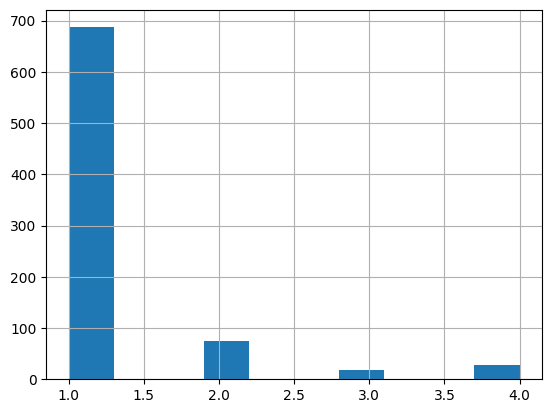

In [43]:
# group by idcopro and count the number of rows
df_prepare_rapprochement.groupby('idcopro').size().hist()

In [17]:
# group by idcopro and aggregate the rnb_id_from_ban_id column as an array and the address_clean column as a set
df_grouped = df_prepare_rapprochement
df_grouped['rnb_id_from_ban_id'] = df_grouped['rnb_id_from_ban_id'].apply(eval)
df_grouped = df_prepare_rapprochement.groupby('idcopro').agg({'rnb_id_from_ban_id': 'sum', 'adresse_clean': 'unique'}).reset_index()
df_grouped.head()


,idcopro,rnb_id_from_ban_id,adresse_clean
0,RNC_AA0002402,"[Z97YB2368XW6, QV4J19G8KGFW, AV61KT3TG2R2, E81...",[1 r des forges 69290 Grézieu-la-Varenne]
1,RNC_AA0002576,[VWPCPMJ9MFSK],[15 r de trion 69005 Lyon]
2,RNC_AA0002659,[9HFFHQ6SMXEA],[20 r bodin 69001 Lyon]
3,RNC_AA0002733,"[D7SM5FRG3SXQ, C87RA7RR9KG4]",[20 r marteret 69100 Villeurbanne]
4,RNC_AA0002816,[N1FX24665KF2],[11 avenue du nord 69160 Tassin-la-Demi-Lune]


<Axes: >

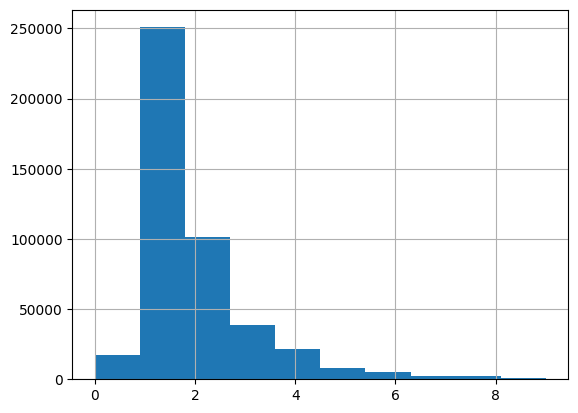

In [20]:
# show hist between 0 and 10
df_grouped['rnb_id_from_ban_id'].apply(len)[df_grouped['rnb_id_from_ban_id'].apply(len) < 10].hist()


In [21]:
# filter out the rows where the number of rnb_id_from_ban_id is 0
df_grouped_filter = df_grouped[df_grouped['rnb_id_from_ban_id'].apply(len) > 0]
df_grouped_filter.shape

(435817, 3)

In [25]:
# save the result to a csv file
df_grouped.to_csv('notebooks/rapprochements/RNC/rapprochement.csv', index=False)

In [24]:
df_grouped.sample(100)

,idcopro,rnb_id_from_ban_id,adresse_clean
95700,RNC_AB5378526,[YTKH6X144QMT],[27 r beaurepaire 75010 Paris]
416050,RNC_AH4854097,"[VFQ5TQCVE1HV, FDBHDH84X3HZ, WDPDDECR1MPK]",[226 chemin de tremouries 83310 Cogolin]
175655,RNC_AC8236580,[],[125 boulevard de la republique 84350 Courthézon]
190021,RNC_AD0437947,[2XVNDHHSD5SB],[67 avenue du 6 juin 14100 Lisieux]
113313,RNC_AB7986524,[P3DATTF9FX4H],[4/6 avenue charles de gaulle 23000 Guéret]
271539,RNC_AE3997822,[8V78TNEXKQWN],[32 r des veaux 67800 Bischheim]
148362,RNC_AC3759644,[6DPJ8B4V7G7W],[5 r des carmes 38200 Vienne]
2824,RNC_AA0679001,"[QWD233J4Z32A, Q4V335V97ZZW, RYDCWNXDG7PE, N65...",[35 avenue du general de gaulle 91140 Villebon...
337682,RNC_AF7871197,[4ZQ13CNNSCB4],[14 r des vosges 67230 Huttenheim]
120720,RNC_AB9074691,[2WYV9N2PRJRE],[54/56 boulevard du marechal juin 6800 Cagnes-...
